<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S2_mobilenet_v2_custom_dataset/Training/EVA4_S2_mobilnet_v2_transfer_learning_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load standard Libraries, Load Drive, Load project modules**

In [2]:
pip install torch-lr-finder

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!rm -rf final_images
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/final_images_ver2.zip
!unzip -q final_images_ver2.zip
!mv /content/final_images_ver2 /content/final_images
!rm -rf /content/__MACOSX
!find /content/final_images -name '.DS_Store' -type f -delete

In [5]:
# Load modules/models from EVA course
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

  pip install torch-lr-finder -v --global-option="amp"


In [6]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

# 2. Load Data & Set Data Loaders

In [7]:
from Modules import *

Calaculate mean and standard deviation for the data

In [7]:
find_mean_standard_deviation("/content/final_images/")

['Small QuadCopters', 'Winged Drones', 'Large QuadCopters', 'Flying Birds']
[0.53713346 0.58979464 0.62127595] [0.36370101 0.41305828 0.47454762] [0.27420551 0.25534403 0.29759673] 1898777428


In [8]:
split_test_train_data('/content/final_images', tstRatio = 0.3)

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
6421
3309
3097
4609


Load images in to DataSet and also perform data transforms

In [10]:
batch_size = 192
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.53713346, 0.58979464, 0.62127595],[0.27420551, 0.25534403, 0.29759673])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.53713346, 0.58979464, 0.62127595],[0.27420551, 0.25534403, 0.29759673])
    ]),
}

trnTransform = data_transforms['train'] 
trainSet = DroneDataset(train=True, transform = trnTransform)

tstTransform = data_transforms['val']
testSet = DroneDataset(train= False, transform = tstTransform)

dataloaders = {'train': torch.utils.data.DataLoader(trainSet, batch_size= batch_size, 
                                                    shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(testSet, batch_size= batch_size,
                                          shuffle=True, num_workers=4)}

dataset_sizes = {'train': len(trainSet),
                 'val':len(testSet)}

class_names = trainSet.classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

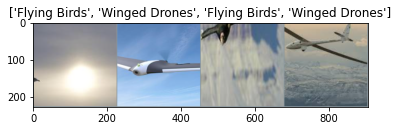

In [11]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4,:,:,:])

imshow_save(out, save_as="sample.jpg",title=[class_names[int(x)] for x in classes[0:4]])

#6. Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [12]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Find hyper parameter lr value using LR Finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


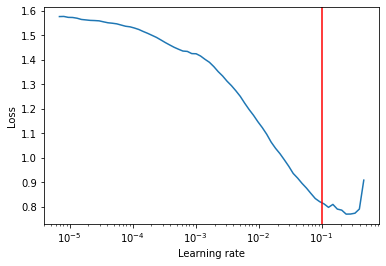

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.1) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [14]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.01, momentum=0.09)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.1, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs 
                                          epochs=25)

# 7. Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [15]:
model_res, plotData = train_model(model_ft, dataloaders, dataset_sizes, device, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.8167 Acc: 0.7116
val Loss: 0.4758 Acc: 0.8747

Epoch 1/24
----------
train Loss: 0.5403 Acc: 0.8232
val Loss: 0.3759 Acc: 0.8868

Epoch 2/24
----------
train Loss: 0.4747 Acc: 0.8385
val Loss: 0.3352 Acc: 0.8948

Epoch 3/24
----------
train Loss: 0.4380 Acc: 0.8524
val Loss: 0.3118 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4198 Acc: 0.8545
val Loss: 0.2948 Acc: 0.8983

Epoch 5/24
----------
train Loss: 0.4111 Acc: 0.8549
val Loss: 0.2897 Acc: 0.9013

Epoch 6/24
----------
train Loss: 0.4000 Acc: 0.8588
val Loss: 0.2783 Acc: 0.9013

Epoch 7/24
----------
train Loss: 0.3943 Acc: 0.8555
val Loss: 0.2724 Acc: 0.9040

Epoch 8/24
----------
train Loss: 0.3778 Acc: 0.8629
val Loss: 0.2741 Acc: 0.9040

Epoch 9/24
----------
train Loss: 0.3798 Acc: 0.8588
val Loss: 0.2698 Acc: 0.9036

Epoch 10/24
----------
train Loss: 0.3797 Acc: 0.8614
val Loss: 0.2641 Acc: 0.9067

Epoch 11/24
----------
train Loss: 0.3722 Acc: 0.8675
val Loss: 0.2572 Acc: 0.9074

Epoch 12/24
----------
t

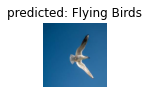

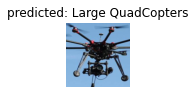

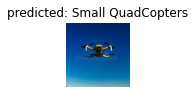

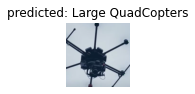

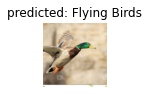

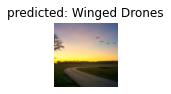

In [16]:
visualize_model(model_res, dataloaders, class_names, device,6,"visualize_1.jpg")

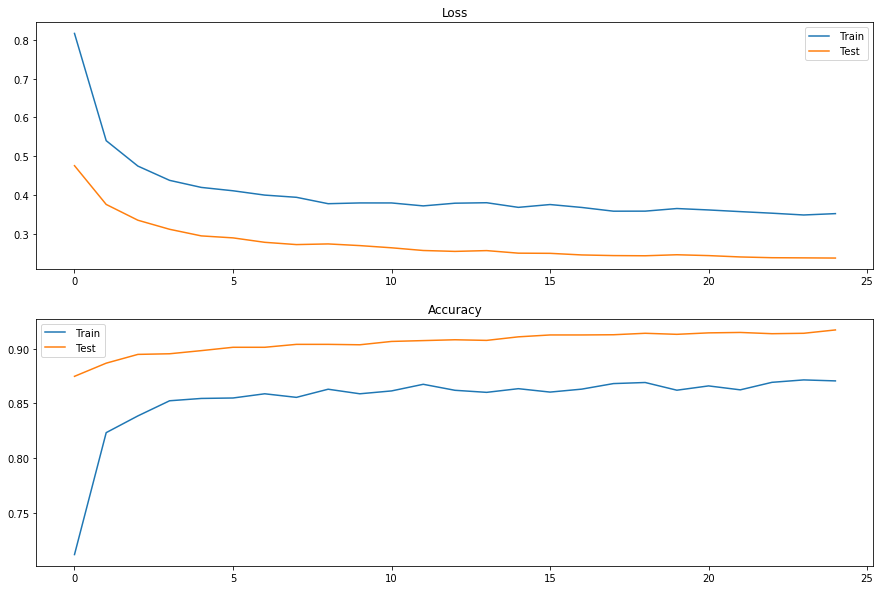

In [17]:
PlotGraph(plotData,"loss_accuracy_1.jpg")

# 8. ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

In [18]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


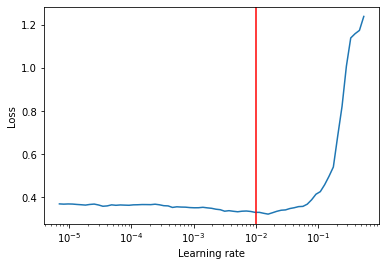

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.01) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [20]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.01, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          epochs=25,
                                          pct_start=0.2, div_factor=10, final_div_factor=100)

In [21]:
model_final, plotData = train_model(model_conv, dataloaders, dataset_sizes, device, criterion, optimizer_conv, scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3262 Acc: 0.8774
val Loss: 0.2059 Acc: 0.9264

Epoch 1/24
----------
train Loss: 0.2716 Acc: 0.8971
val Loss: 0.1780 Acc: 0.9396

Epoch 2/24
----------
train Loss: 0.2472 Acc: 0.9053
val Loss: 0.1760 Acc: 0.9363

Epoch 3/24
----------
train Loss: 0.2425 Acc: 0.9088
val Loss: 0.2016 Acc: 0.9302

Epoch 4/24
----------
train Loss: 0.2225 Acc: 0.9180
val Loss: 0.1479 Acc: 0.9501

Epoch 5/24
----------
train Loss: 0.2030 Acc: 0.9236
val Loss: 0.1594 Acc: 0.9465

Epoch 6/24
----------
train Loss: 0.1951 Acc: 0.9286
val Loss: 0.1791 Acc: 0.9356

Epoch 7/24
----------
train Loss: 0.1875 Acc: 0.9300
val Loss: 0.1507 Acc: 0.9499

Epoch 8/24
----------
train Loss: 0.1798 Acc: 0.9341
val Loss: 0.1515 Acc: 0.9520

Epoch 9/24
----------
train Loss: 0.1720 Acc: 0.9353
val Loss: 0.1536 Acc: 0.9526

Epoch 10/24
----------
train Loss: 0.1588 Acc: 0.9418
val Loss: 0.1418 Acc: 0.9556

Epoch 11/24
----------
train Loss: 0.1502 Acc: 0.9437
val Loss: 0.1426 Acc: 0.9591

Ep

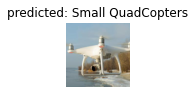

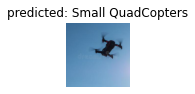

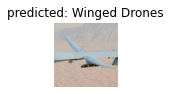

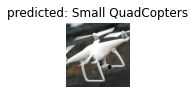

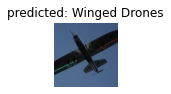

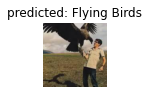

In [22]:
visualize_model(model_res, dataloaders, class_names, device,6,"visualize_2.jpg")
plt.ioff()
plt.show()

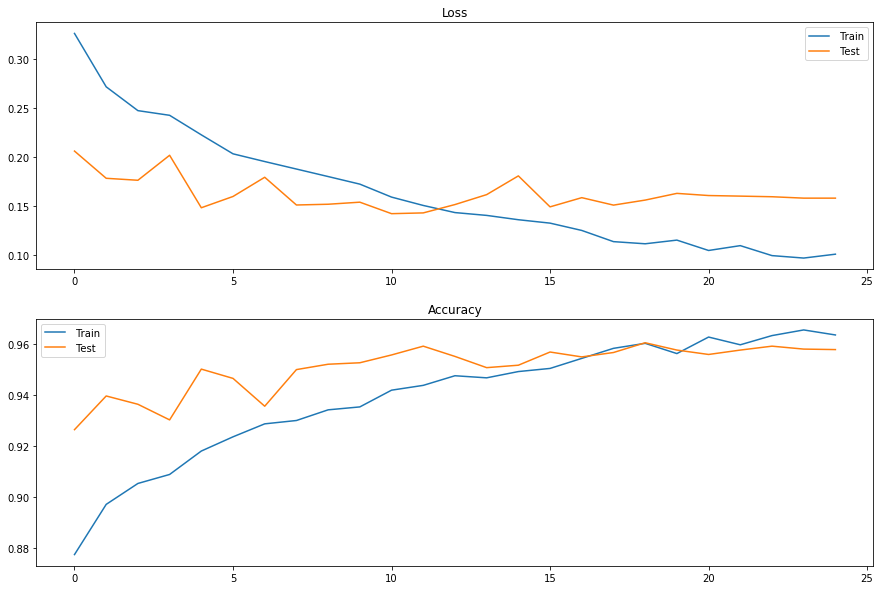

In [23]:
PlotGraph(plotData,"loss_accuracy_2.jpg")

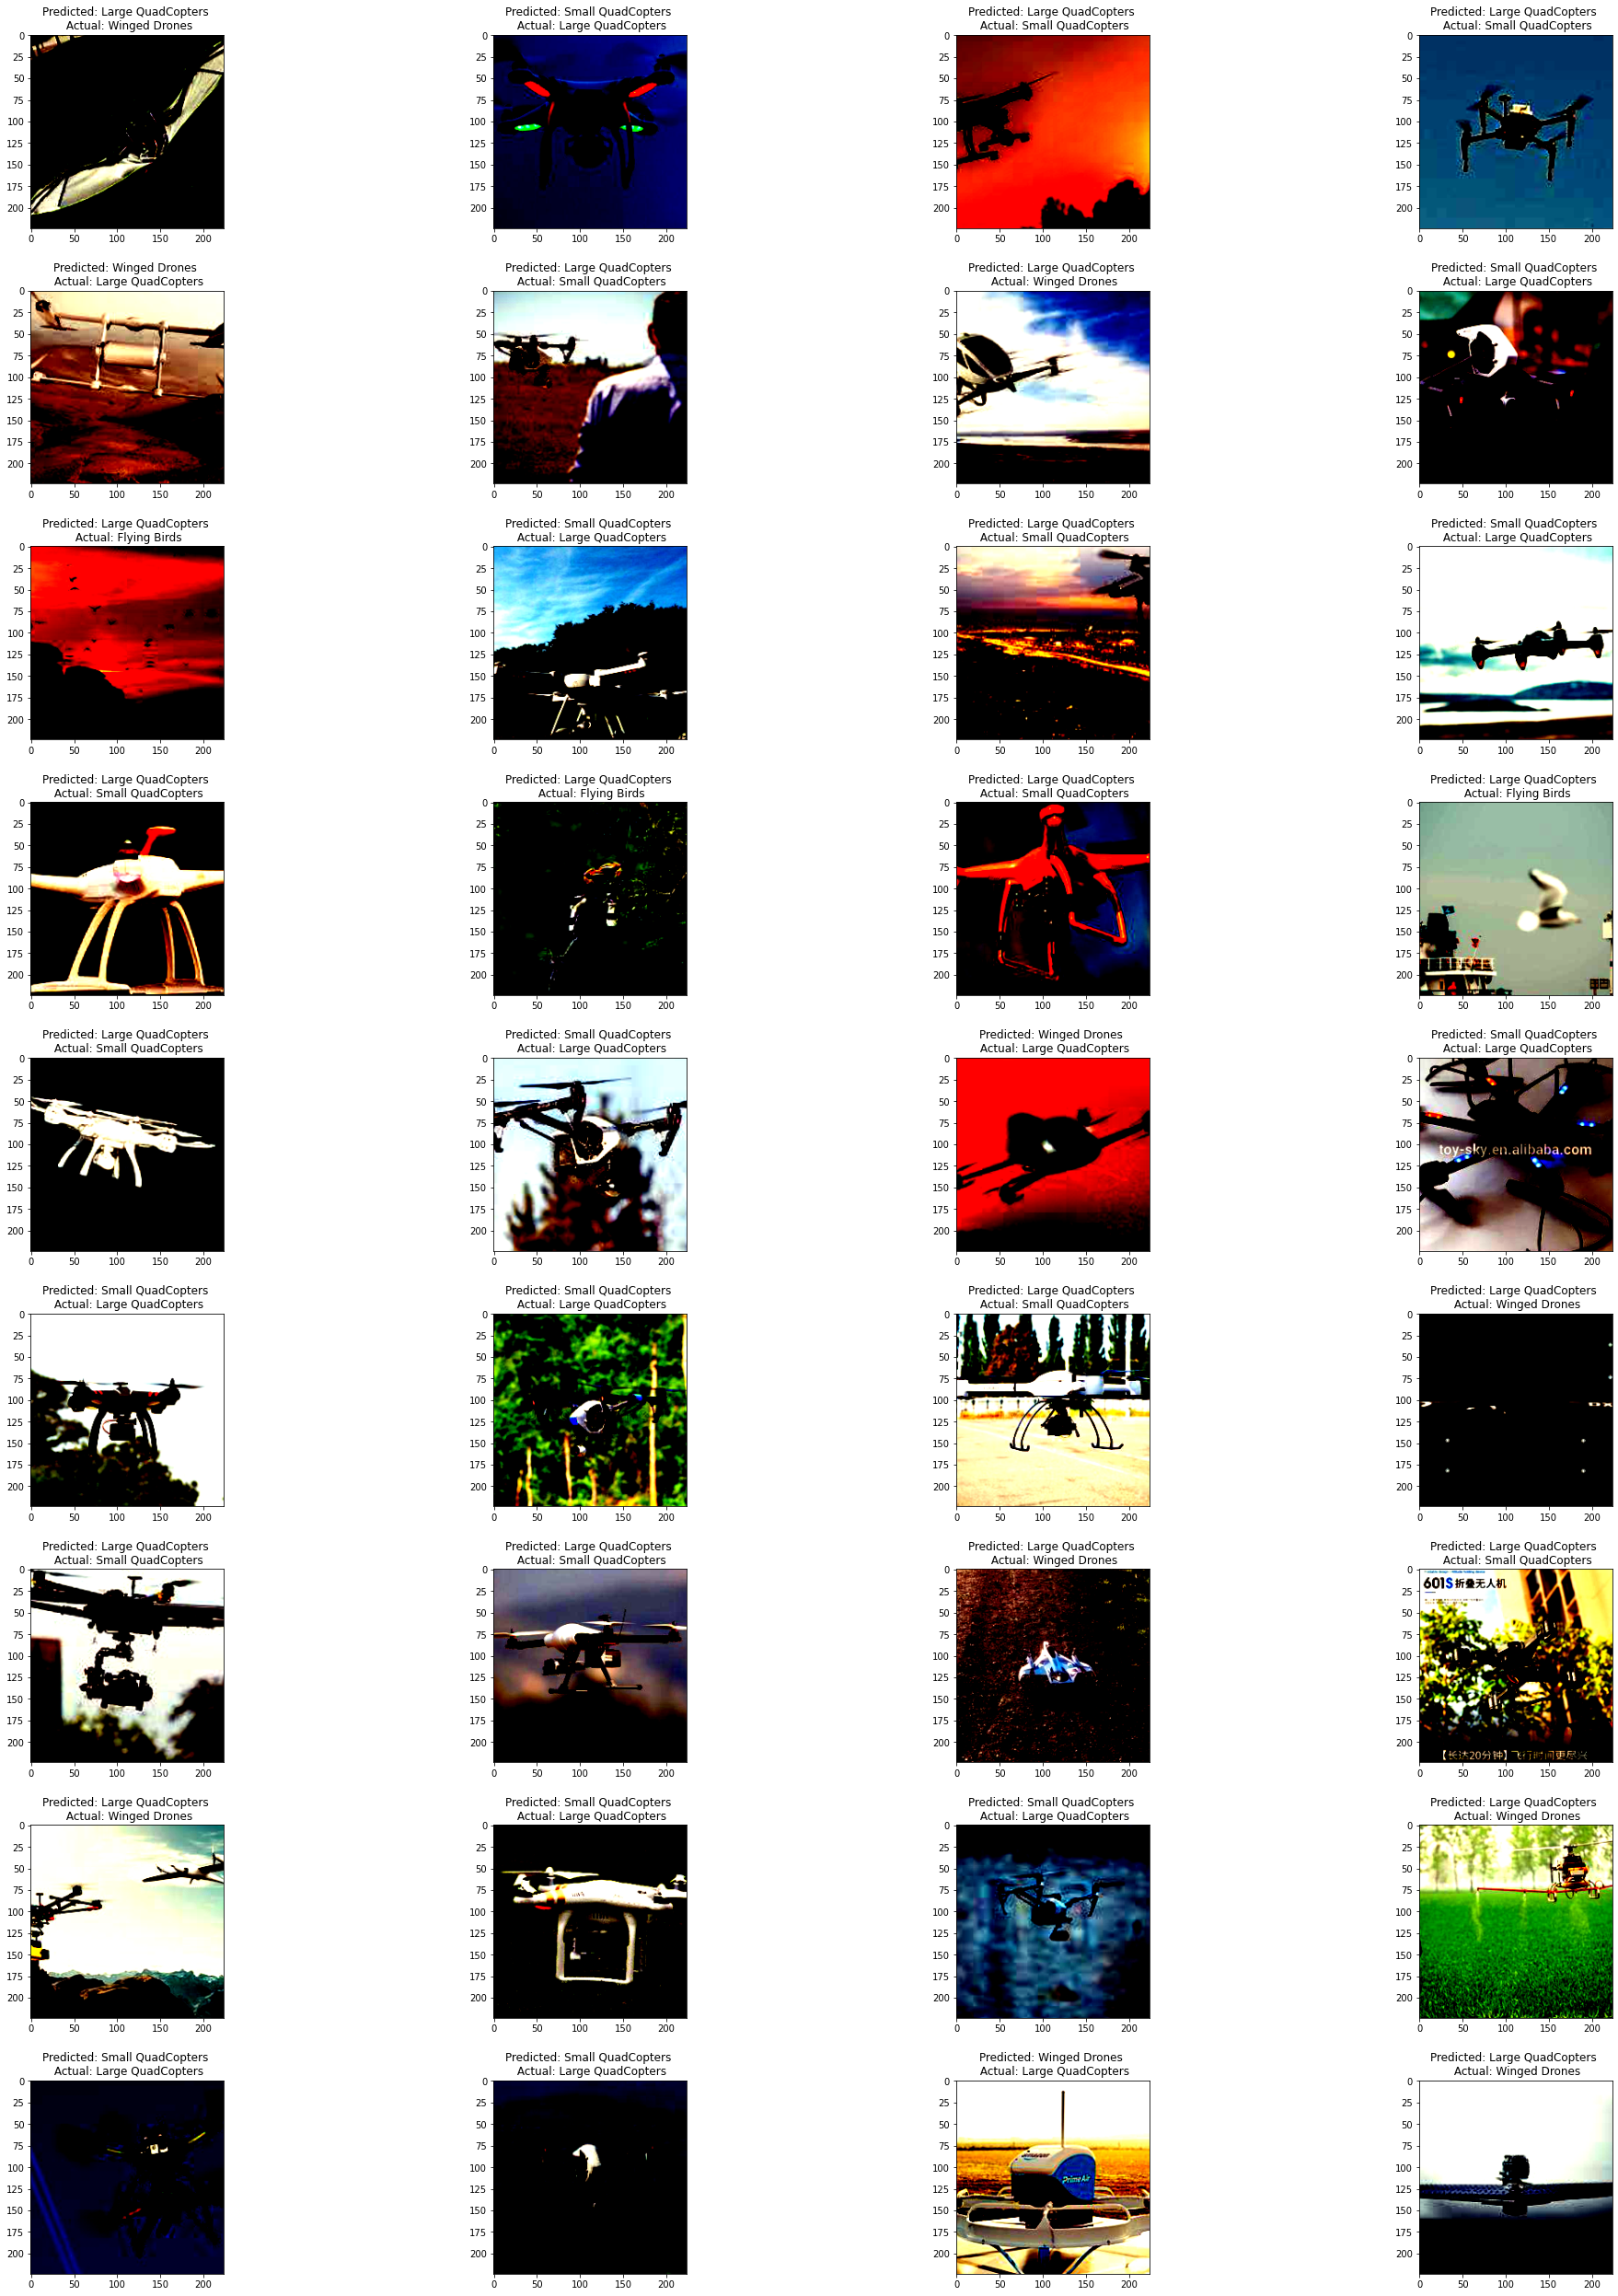

In [24]:
ShowMissclassifiedImages(model_final, dataloaders, class_names, device,save_as="misclassified.jpg")

# 9. Saving Model

In [25]:
# Save GPU Model
torch.save(model_final.state_dict(), '/content/mobilenet_v2_custom_trained_gpu_v5.pt')

# Load CPU Model
device = torch.device('cpu')
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(1280, 4)
model.load_state_dict(torch.load('/content/mobilenet_v2_custom_trained_gpu_v5.pt',
                                 map_location=device))

# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_model.save('mobilenet_v2_custom_trained_v5.pt')